In [ ]:
My model explains the data discussed in the paper in the following way. It is build on the assumptions that the 
length of a foreperiod of a previous trial in combination with the length of the foreperiod in the current trial
influences response times. 
For every trial there is a chunk stored that holds both the time of the current fp and the pulses of this current 
fp (which represents the internal clock). Every trial, with exception of the first trial for each subject, a chunk
with the highest activation level is retrieved. From this chunk, the pulses of the time belonging to that fp will be 
transferred back to time, representing the subjects estimate of the current fp in this trial. 
If this estimate (taken from a previous fp) is bigger than the current fp, the subject is prepared and 0.05 s 
will be taken from the max response time of 0.41 s. 
If this estimate (taken from a previous fp) is smaller than the current fp, the subject is unprepared and there
will be a max response time of 0.41 s. 
If this estimate (taken from a previous fp) is bigger than the current fp, is in between the time of 
current foreperiod - 50 ms and the estimate for the next foreperiod, the response time has to be calculated by 
taking the max response time and withdrawing the current foreperiod - their estimate
After every trial, a new chunk will be made that holds the information about the fp in the current trial, so
that it could be retrieved to make an estimate at a later moment again. In other words, every trial a new
chunk will be made. 
In between each trial I added an interval of 1.0 - 1.5 s, which influences the activation level of every chunk
because it causes a decay in memory. 
I made a list of 'current' fps (fp1), from which the model randomly draws an fp every single trial. After every 
trial I replace fp0 by fp1, so that the fp1 is stored. In the following trial, our fp0 then represents
the foreperiod of the previous trial. The current foreperiod (fp1) is then, again, randomly drawn from the list.

The model certaintly is not a perfect fit. The lines do follow a similar trend to the model presented in the
assignment, but there is room for improvement. Perhaps it could be improved by using a different kind of retrieval
or adjusting noise levels. 

In [10]:
from model import Model
from dmchunk import Chunk
import pandas as pd
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

In [12]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

In [13]:
intervals = [0, 0.011, 0.025, 0.1, 0.5, 1, 10]
print("t (s)", "\t", "pulses")
for t in intervals:
    print(t, "\t", time_to_pulses(t))

t (s) 	 pulses
0 	 0
0.011 	 1
0.025 	 2
0.1 	 6
0.5 	 17
1 	 25
10 	 49


In [14]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

In [1]:
#create a list of fp1 to choose from for each trial
time=[0.4, 0.8, 1.2, 1.6]

#10 subs otherwise it takes too long
def period(fp1, subs = 10):
    
    #creating empty dataframe of fp0, subject, response and fp1 to which we will add all information so we can plot
    results = pd.DataFrame(columns = ['fp0', 'sub', 'response', 'fp1'])
    
    #create model
    for sub in range(subs):
        m  = Model()
        
        #896 trials like the assignment said
        for i in range(896):
            
            # every trial there was a randomly jittered inter-trial interval of 1.0 - 1.5s 
            interval = random.uniform(1, 1.5)
            
            #add this interval to the model time
            m.time+= interval
            
            #pick a random fp1 from the time list
            fp1 =  random.choice(time)
            
            #for the first trial there is nothing in memory, so our previous pulse guess (previousFP) will be
            #same as the fp1
            if i==0:
                
                #make a memory chunk that stores the current time of fp1 and the pulse of this time
                fp0_estimate = Chunk(name = "new_estimate_pulse"+str([i]), slots = {"previous time": fp1, 
                                                                    "previous pulse guess": time_to_pulses(fp1)})
                
                #replace the previous fp0 by the current fp1 so that in the next trial fp0 is the foreperiod of the
                #last trial
                fp0=fp1
                
                #add the chunk to memory
                m.add_encounter(fp0_estimate)
                
                #increase time by our fp1
                m.time += fp1
                
                #skip over the rest of the loop since this only happens in the first trial
                continue  

            #retrieve the pulse guess and latency from the chunk with the highest activation 
            fp0_estimate, latency = m.retrieve_partial(fp0_estimate)
             
            #if the model can retrieve a chunk    
            if fp0_estimate != None: 
                #transfer this pulse guess back to time, which represents the model's 
                #estimate for the next foreperiod 
                previousFP = pulses_to_time(fp0_estimate.slots["previous pulse guess"])
             
            #if there is nothing retrieved from memory, set a high number so there will be a maximum response time
            else:
                previousFP=2
                
            #if this estimate for the next foreperiod is larger than the current foreperiod, response time
            #the subject is unprepared and will have a max response time of 410 ms
            if previousFP > fp1:
                response = 0.410
            
            #if this estimate for the next foreperiod is smaller than when the current foreperiod - 50 ms, 
            #the subject is prepared and their response time will be 50 ms shorter
            if previousFP < fp1 - 0.05:
                response = 0.410 - 0.05
                
            #if estimate for the next foreperiod is in between the time of current foreperiod - 50 ms and
            #the estimate for the next foreperiod, the response time has to be calculated by 
            #taking the max response time and withdrawing the current foreperiod - their estimate
            if previousFP > fp1 - 0.05 and previousFP < fp1:
                response = 0.410 - (fp1 - previousFP)
            
            #make a new chunk for each new foreperiod estimate
            fp0_estimate = Chunk(name = "new_estimate_pulse"+str([i]), slots = {"previous time": fp1, 
                                                                "previous pulse guess": time_to_pulses(fp1)})
            #store every new chunk in memory
            m.add_encounter(fp0_estimate)
            
            #increase time by the latency and the time of the current foreperiod
            m.time += latency
            m.time += fp1
                
            #add all information to the results dataframe for plotting    
            results.loc[len(results)] = [fp0, sub, response, fp1]
            
            #replace the previous fp0 by the current fp1 so that in the next trial fp0 is the foreperiod of the
            #last trial
            fp0=fp1
     
    #plot
    fig, ax = plt.subplots(figsize=(15,8))
    results.groupby(['fp1','fp0']).mean()['response'].unstack().plot(ax=ax)


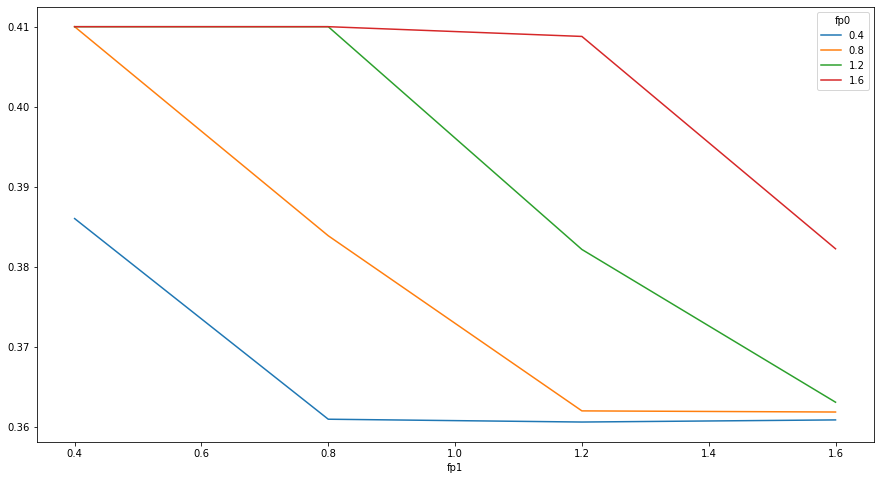

In [168]:
period(fp1)